## libraries

In [145]:
import pandas as pd
import numpy as np
import glob
import os
import sys

from tqdm import tqdm
from joblib import dump, load 

import matplotlib.pyplot as plt

from ctgan import CTGAN
from table_evaluator import load_data, TableEvaluator

In [146]:
import warnings
warnings.filterwarnings("ignore")

## data

In [282]:
X_tr_list = sorted(glob.glob('../data/train_input/*.csv')) 
X_te_list = sorted(glob.glob('../data/test_input/*.csv'))
y_tr_list = sorted(glob.glob('../data/train_target/*.csv'))
y_te_list = sorted(glob.glob('../data/test_target/*.csv'))
print('train :', len(X_tr_list), len(y_tr_list))
print('test  :', len(X_te_list), len(y_te_list))

train : 28 28
test  : 5 5


## preprocessing

In [283]:
case_0 = pd.read_csv(X_tr_list[0])
case_0

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
1,0,01:00,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
2,0,02:00,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
3,0,03:00,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
4,0,04:00,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.00,0.00,0.000,0.000,0,0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19:00,30.880000,82.255000,464.433333,0.000000,252.0,3638.54,18255.19,254644.43,976.332,13619.004,0,0,19231.522,268263.434
668,27,20:00,29.068333,82.506667,534.633333,0.000000,126.0,3764.54,618.82,255263.25,33.096,13652.100,0,0,651.916,268915.350
669,27,21:00,28.246667,82.835000,563.433333,0.000000,0.0,3764.54,0.00,255263.25,0.000,13652.100,0,0,0.000,268915.350
670,27,22:00,28.005000,82.850000,577.150000,0.000000,126.0,3890.54,0.00,255263.25,0.000,13652.100,0,0,0.000,268915.350


In [285]:
def ctgan_preprocessing(df): # input : case df

    # shape of raw data
    raw_shape = df.shape
       
    # input df
    df['obs_time'] = df.index % 24
        
    # limit data range
    df.loc[(df['내부온도관측치'] > 40), '내부온도관측치'] = 40
    df.loc[(df['내부습도관측치'] > 100), '내부습도관측치'] = 100
    df.loc[(df['co2관측치'] > 1200), 'co2관측치'] = 1200
    df.loc[(df['ec관측치'] > 8), 'ec관측치'] = 8
    df.loc[(df['시간당분무량'] > 3000), '시간당분무량'] = 3000
    df.loc[(df['시간당백색광량'] > 120000), '시간당백색광량'] = 120000
    df.loc[(df['시간당적색광량'] > 120000), '시간당적색광량'] = 120000
    df.loc[(df['시간당청색광량'] > 120000), '시간당청색광량'] = 120000
    df.loc[(df['시간당총광량'] > 120000), '시간당총광량'] = 120000
    df.loc[(df['내부온도관측치'] < 0), '내부온도관측치'] = 0
    df.loc[(df['내부습도관측치'] < 0), '내부습도관측치'] = 0
    df.loc[(df['co2관측치'] < 0), 'co2관측치'] = 0
    df.loc[(df['ec관측치'] < 0), 'ec관측치'] = 0
    df.loc[(df['시간당분무량'] < 0), '시간당분무량'] = 0
    df.loc[(df['시간당백색광량'] < 0), '시간당백색광량'] = 0
    df.loc[(df['시간당적색광량'] < 0), '시간당적색광량'] = 0
    df.loc[(df['시간당청색광량'] < 0), '시간당청색광량'] = 0
    df.loc[(df['시간당총광량'] < 0), '시간당총광량'] = 0    
    df['시간당총광량'] = df['시간당청색광량'] + df['시간당백색광량'] + df['시간당적색광량']
        
    cols = df.columns

    # cumsum cols
    for i in range(0, len(cols)):
        col = cols[i]

        if '누적' in col:
            # df[col] = df.groupby((df.obs_time == 0).cumsum()).agg(cols[i - 1]).cumsum()
            df.drop([col], axis=1, inplace=True)
        
    df.drop(['시간당총광량'], axis=1, inplace=True)
    print(f'Done. (ctgan preprocessing {raw_shape} => {df.shape})')

    return df

In [286]:
X_case_0 = ctgan_preprocessing(case_0)
X_case_0

Done. (ctgan preprocessing (672, 16) => (672, 10))


,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.000,0
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,0.00,0.000,0
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,0.00,0.000,0
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,0.00,0.000,0
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,0.00,0.000,0
...,...,...,...,...,...,...,...,...,...,...
667,27,19,30.880000,82.255000,464.433333,0.000000,252.0,18255.19,976.332,0
668,27,20,29.068333,82.506667,534.633333,0.000000,126.0,618.82,33.096,0
669,27,21,28.246667,82.835000,563.433333,0.000000,0.0,0.00,0.000,0
670,27,22,28.005000,82.850000,577.150000,0.000000,126.0,0.00,0.000,0


## train

In [242]:
# category cols
discrete_cols = ['DAT', 'obs_time']

# ctgan
model = CTGAN(verbose=True)
model.fit(X_case_0, discrete_cols, epochs=100)

Epoch 1, Loss G:  3.4099,Loss D:  0.0091
Epoch 2, Loss G:  3.3621,Loss D:  0.0077
Epoch 3, Loss G:  3.3152,Loss D: -0.0163
Epoch 4, Loss G:  3.3858,Loss D: -0.0252
Epoch 5, Loss G:  3.3378,Loss D: -0.0486
Epoch 6, Loss G:  3.3401,Loss D: -0.0331
Epoch 7, Loss G:  3.3269,Loss D: -0.0745
Epoch 8, Loss G:  3.3130,Loss D: -0.0761
Epoch 9, Loss G:  3.2659,Loss D: -0.0851
Epoch 10, Loss G:  3.2502,Loss D: -0.0538
Epoch 11, Loss G:  3.2972,Loss D: -0.0868
Epoch 12, Loss G:  3.2433,Loss D: -0.0751
Epoch 13, Loss G:  3.1765,Loss D: -0.1258
Epoch 14, Loss G:  3.1665,Loss D: -0.1080
Epoch 15, Loss G:  3.2038,Loss D: -0.1194
Epoch 16, Loss G:  3.1421,Loss D: -0.1420
Epoch 17, Loss G:  3.1490,Loss D: -0.1166
Epoch 18, Loss G:  3.0342,Loss D: -0.1783
Epoch 19, Loss G:  3.0084,Loss D: -0.1570
Epoch 20, Loss G:  2.9692,Loss D: -0.2150
Epoch 21, Loss G:  2.9366,Loss D: -0.1377
Epoch 22, Loss G:  2.9073,Loss D: -0.2112
Epoch 23, Loss G:  2.8218,Loss D: -0.2102
Epoch 24, Loss G:  2.8204,Loss D: -0.1122
E

In [248]:
# save model
dump(model, '../result/ctgan')

['../result/ctgan']

In [249]:
# load model
load_model = load('../result/ctgan')

## eval

In [263]:
# generate samples based on learned model
aug_samples = model.sample(X_case_0.shape[0])

# result of sorted samples
aug_samples.sort_values(by=['DAT', 'obs_time'], ascending=[True, True], inplace=True)
aug_samples

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량
625,0,0,25.134277,81.709129,601.241478,1.429358,267.150696,17846.223097,130.085806,0
637,0,1,24.778641,80.512496,597.845295,1.417738,44.564356,18157.492775,1032.488777,0
73,0,2,26.153504,79.005043,627.150013,1.345250,140.721588,-2334.209723,986.927692,0
532,0,2,28.075408,77.501650,515.723300,1.381509,268.231676,17427.460724,51.486857,0
490,0,3,26.675557,73.596901,512.657207,1.447960,244.322318,18050.849351,1054.035463,0
...,...,...,...,...,...,...,...,...,...,...
216,27,20,28.278826,82.782669,622.094462,1.437796,265.437590,18161.050113,1033.333186,0
259,27,20,24.943919,82.910100,610.830187,1.483694,259.242288,522.341090,1053.336170,0
336,27,20,26.046949,81.875373,707.964221,1.434721,237.989053,17420.518614,1005.686927,0
195,27,22,26.006558,81.331552,625.777728,1.418060,262.678932,18374.591305,1037.518270,0


In [268]:
X_case_0['obs_time'].value_counts()

0     28
1     28
22    28
21    28
20    28
19    28
18    28
17    28
16    28
15    28
14    28
13    28
12    28
11    28
10    28
9     28
8     28
7     28
6     28
5     28
4     28
3     28
2     28
23    28
Name: obs_time, dtype: int64

In [270]:
# check data shape
X_case_0.shape, aug_samples.shape

((672, 10), (672, 10))

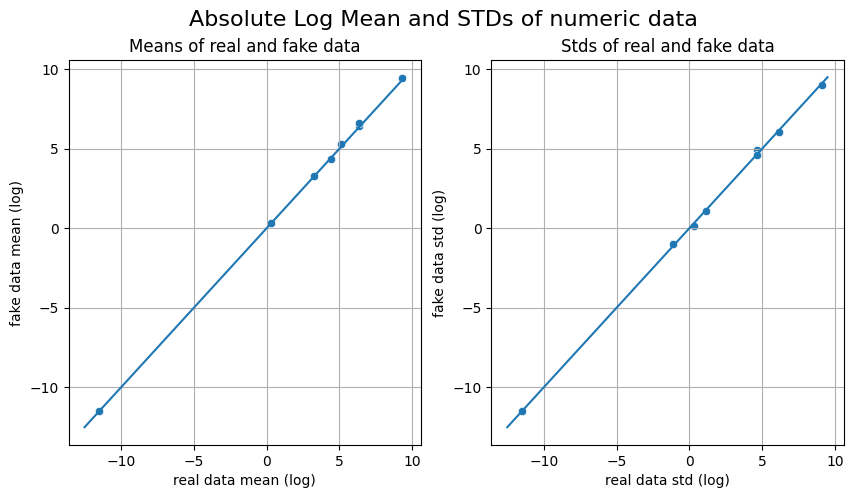

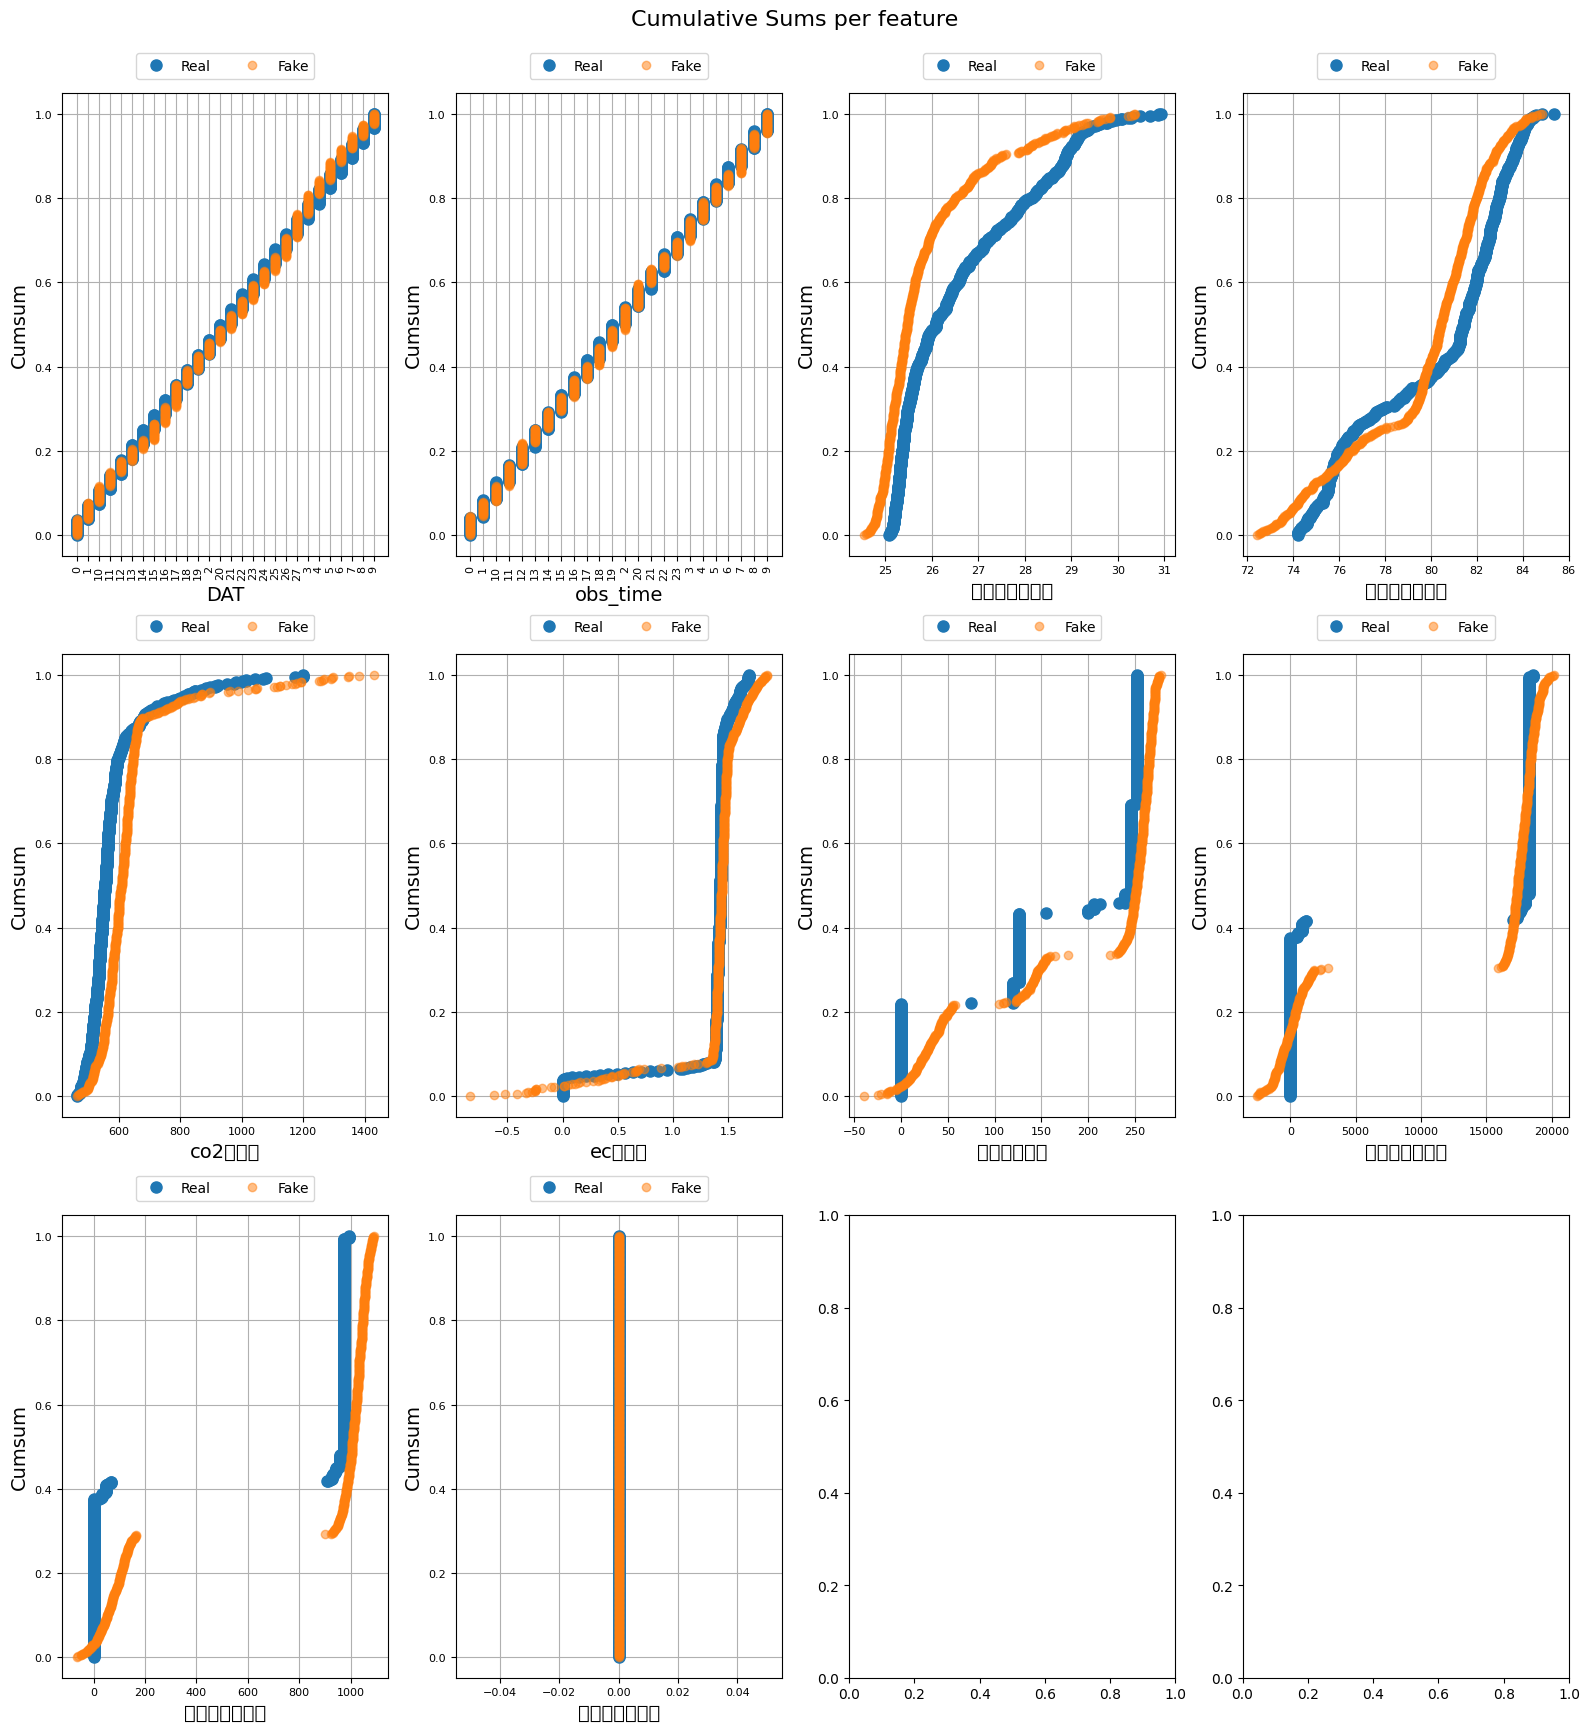

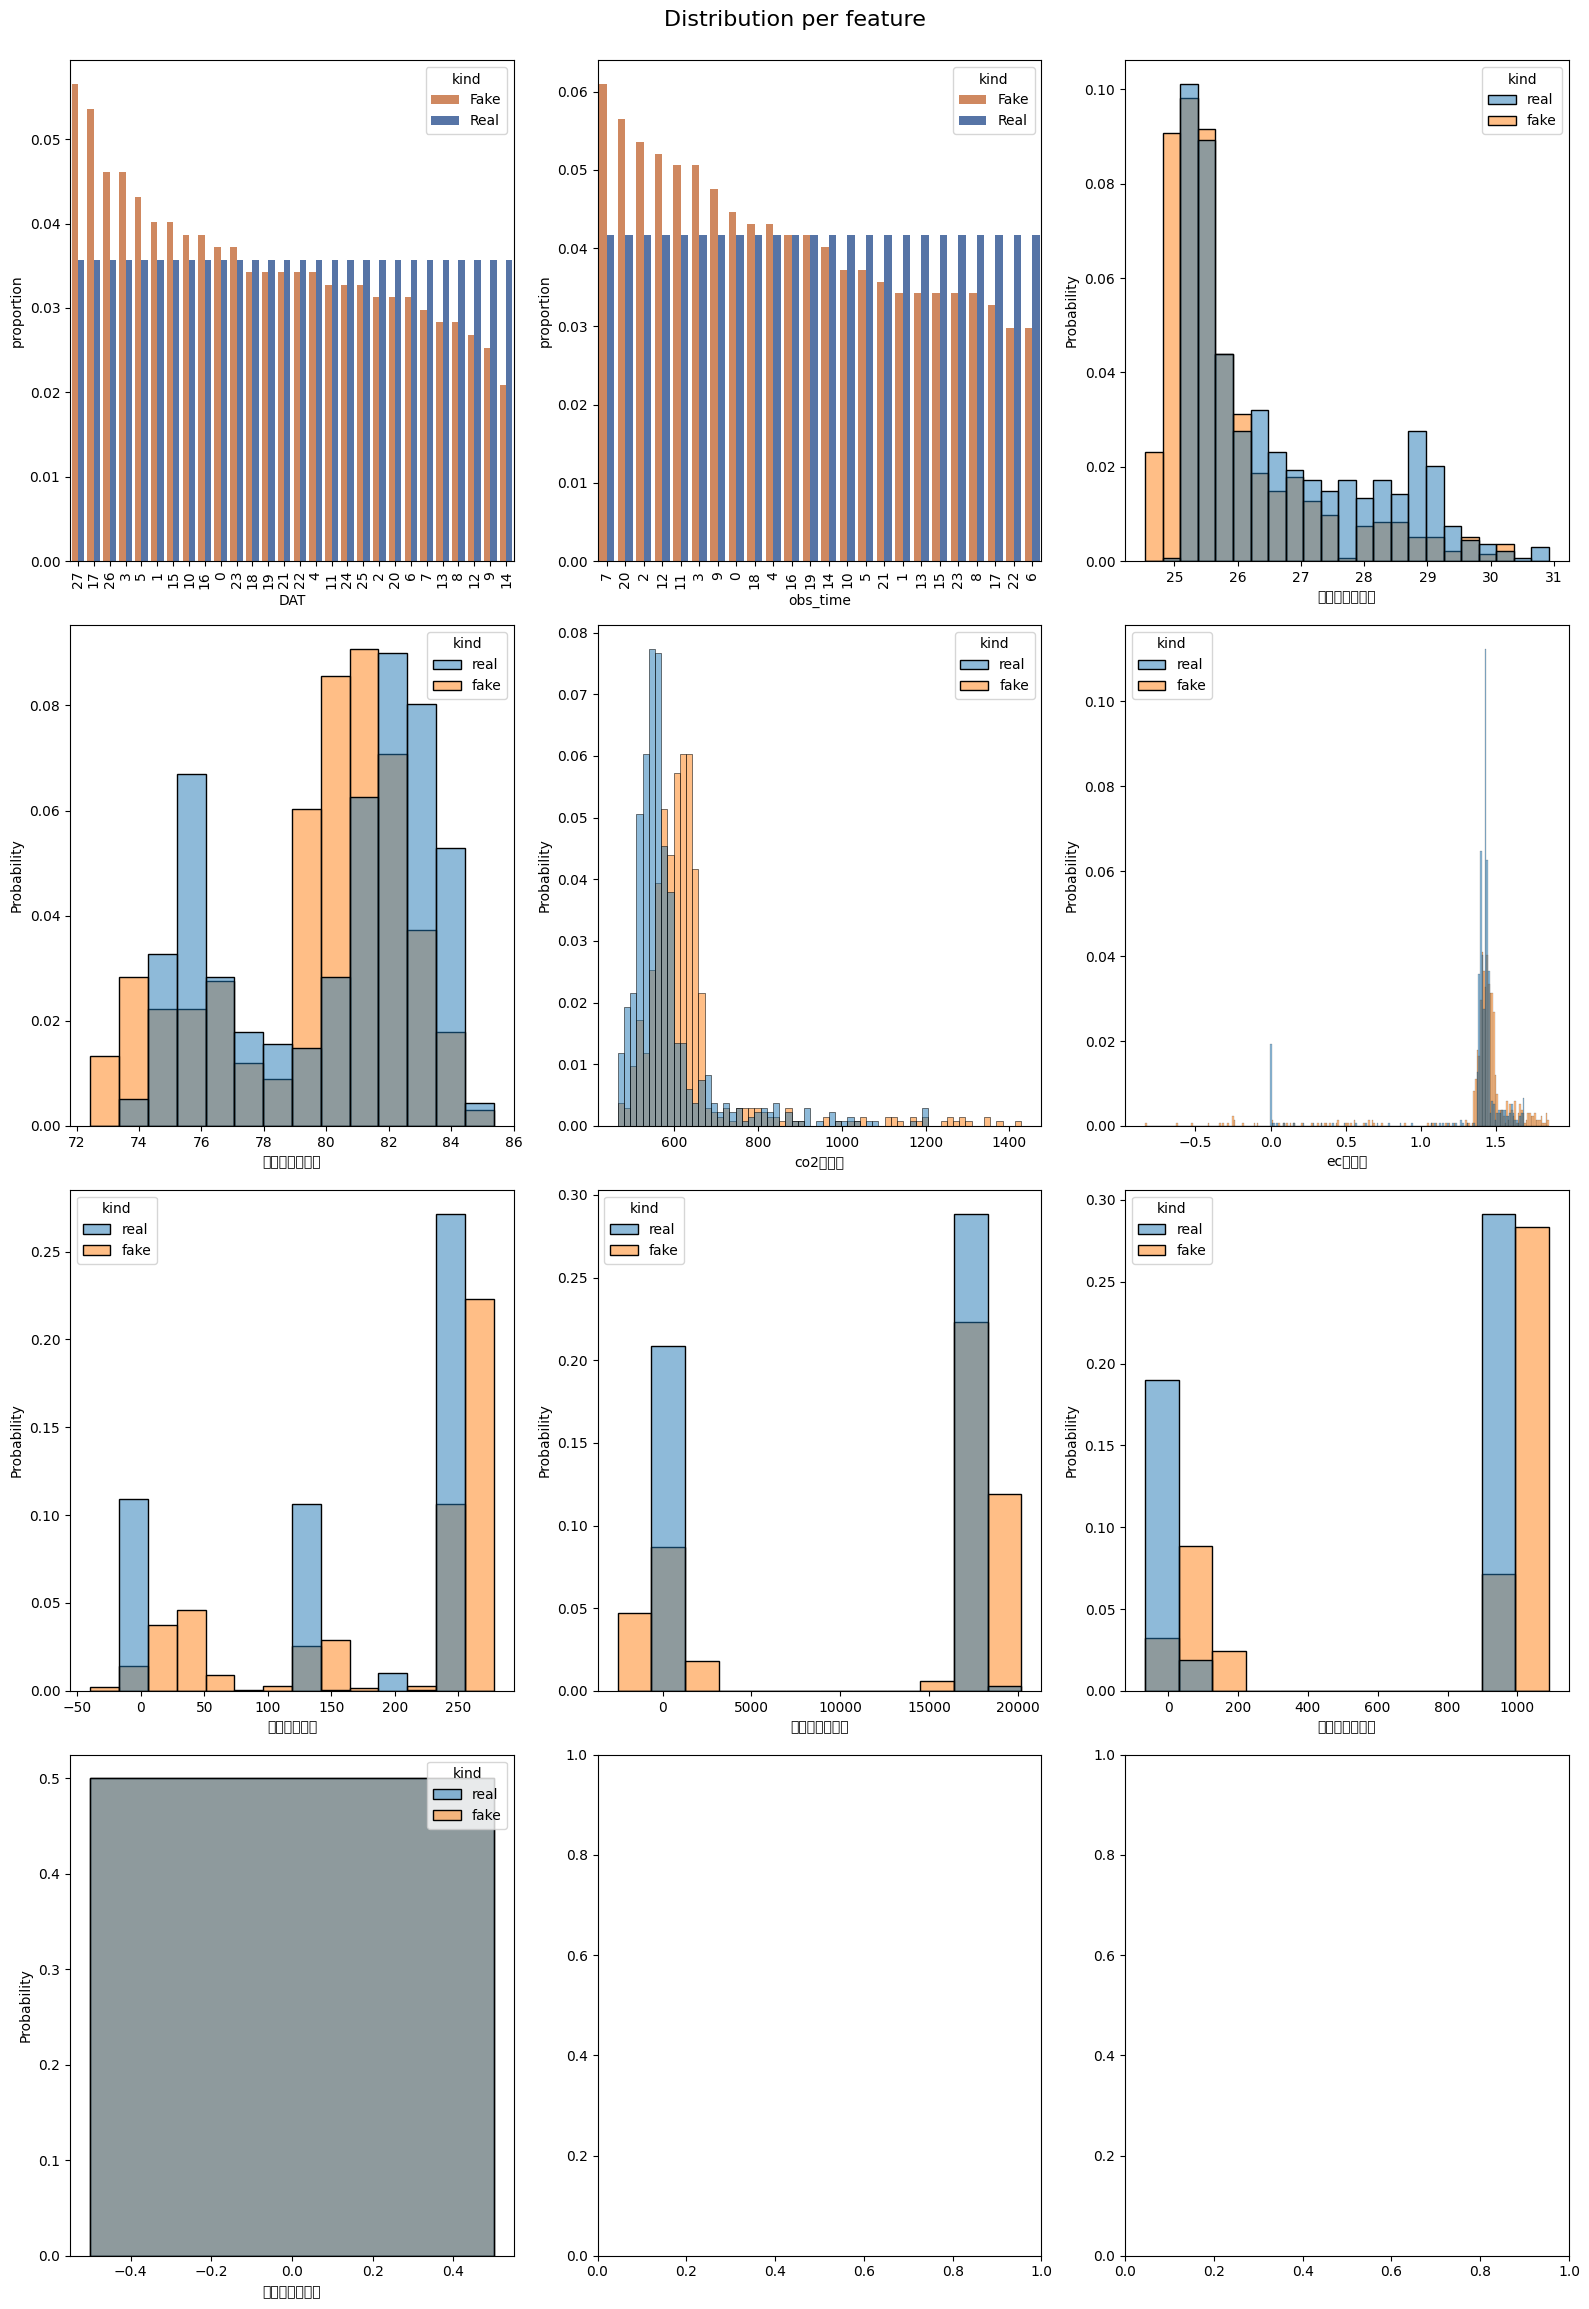

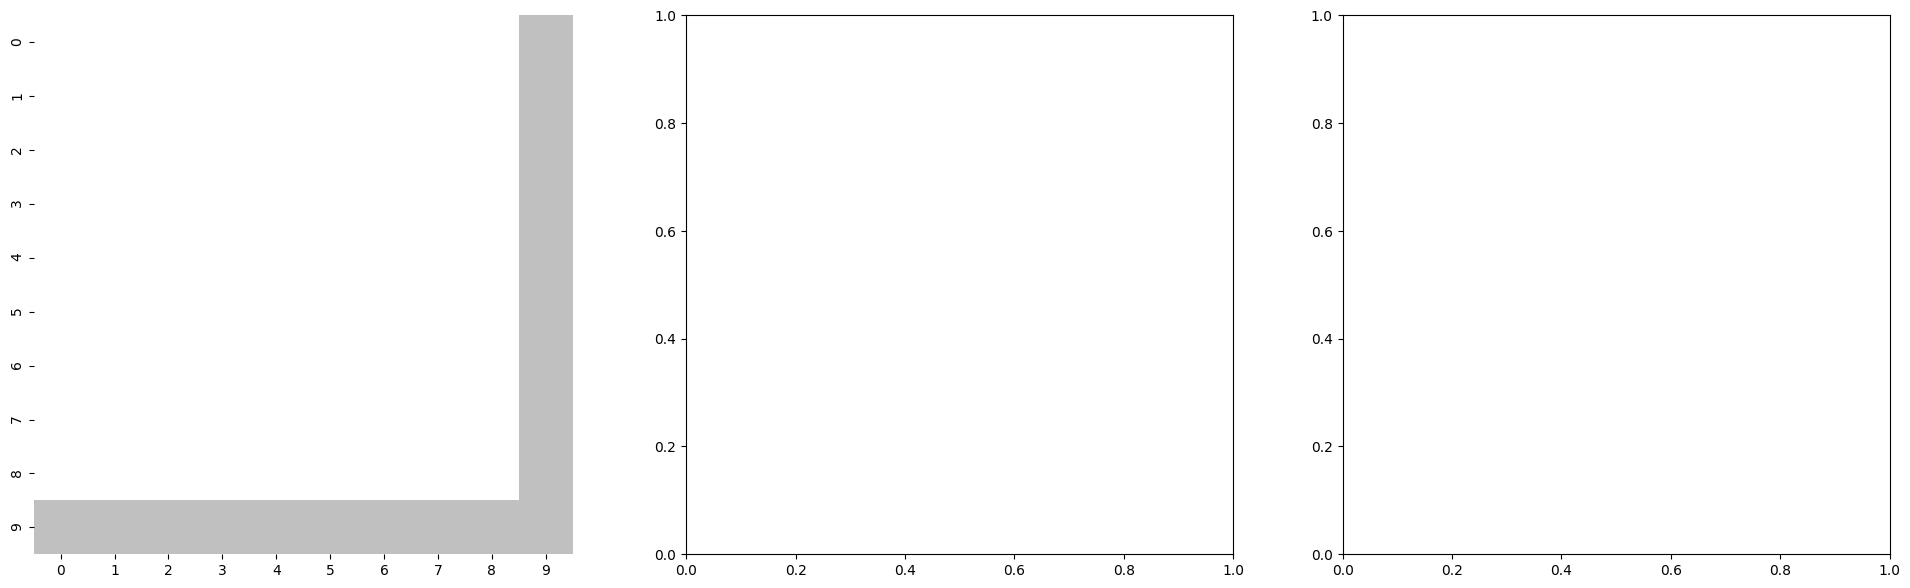

In [271]:
table_evaluator = TableEvaluator(X_case_0, aug_samples, cat_cols=discrete_cols)
try:
    table_evaluator.visual_evaluation()
except:
    pass